In [1]:
import numpy as np
from scipy import linalg
from lanczos import *
import matplotlib.pyplot as plt

Diagonalize matrix C Z = Z Omega^2
10.234233488441397
10.234475897375196
10.234691617419339
11.622967116408192
11.623110824165732
11.62316120696677
11.786040289455174
11.786210630471855
11.921095509887403
11.921098311537135
Diagonalize matrix M V = S V Omega
10.234233488441674
10.23447589737543
10.234691617419614
11.622967116408441
11.623110824166016
11.623161206967008
11.786040289455485
11.786210630472082
11.921095509887659
11.921098311537374
 E = -19.6662 eV;  E^GW (E) = -10.88908359218208 eV E^GW_nanogw -10.92841104000000 eV
 E = -18.6662 eV;  E^GW (E) = -11.56339805626144 eV E^GW_nanogw -11.60254464000000 eV
 E = -17.6662 eV;  E^GW (E) = -12.00939451819951 eV E^GW_nanogw -12.04905302000000 eV
 E = -16.6662 eV;  E^GW (E) = -12.34000286234337 eV E^GW_nanogw -12.38033696000000 eV
 E = -15.6662 eV;  E^GW (E) = -12.60154995896024 eV E^GW_nanogw -12.64264526000000 eV
 E = -14.6662 eV;  E^GW (E) = -12.81744966767957 eV E^GW_nanogw -12.85936628000000 eV
 E = -13.6662 eV;  E^GW (E) = -13.00

[]

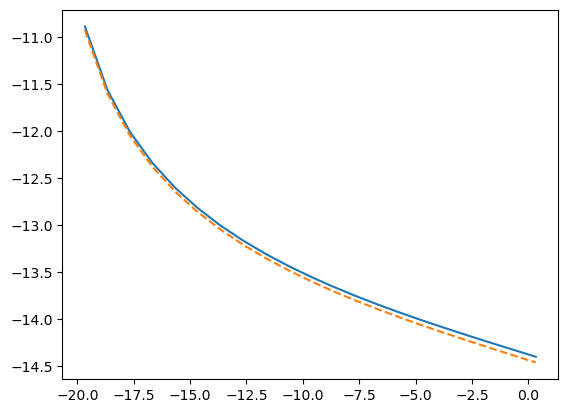

In [2]:
# The energies in the following files are in Rydberg
# Format of different files:
#   "diagonal_el.dat" 
#   iv ic E_c E_v E_c-E_v

#   "k_integrate_1.dat" stores the kernel matrix elements for constructing Casida equation
#   "k_integrate_2.dat" stores the kernel matrix elements for GW calculations (in summations over bands)
#   index  i  a  j  b   (ia|jb) 
#   Notes: here "index" is useless in this file
#     definition of (ia|jb):
#     (ia|jb) = \int \psi_i(r) \psi_a(r) V(r,r') \psi_j(r') \psi_b(r') dr dr', here V(r,r') is Coulomb potential
#     Note there are two different notations for the integral elements, and the relation between these two notations is:  (ia|jb) = <ij|ab>

#   "casida_el.dat" stores the matrix elements of casida equation "C = (A-B)^1/2 (A+B) (A-B)^1/2"
#     n  m  C_nm

eta = 0.0025 # Rydberg
ryd2ev = 13.60517721067
offsetgw = 4
ngw = 2
nv = 4
nc = 26
nb = 30
ncv = nc*nv 

en = np.zeros(nb)
en_assigned = np.zeros(nb,dtype=int)

# Read energies of kohn-sham states
ediff = np.loadtxt("diagonal_el.dat") 
for irow in range(len(ediff)):
    i1 = int(ediff[irow,0]-1)
    i2 = int(ediff[irow,1]-1)
    en[i1] = ediff[irow,3]
    en[i2] = ediff[irow,2]
    en_assigned[i1] = 1
    en_assigned[i2] = 1
    if (not (en_assigned<1).any()): break

# read the map between orbital indices and orbital-pair indices
pairmap = np.zeros((ncv,2), dtype=int)
invpairmap = np.zeros((nv,nb), dtype=int)
for irow in range(len(ediff)):
    iv = int(ediff[irow,0]-1)
    ic = int(ediff[irow,1]-1)
    pairmap[irow,0] = iv
    pairmap[irow,1] = ic
    invpairmap[iv,ic] = irow

# Casida equation 
# | A B |*|X| = | 1 0 |*|X|*Omega
# | B A | |Y|   | 0 -1| |Y|
# read offdiagonal part of casida matrix, i.e., matrix B
# A_iajb = (E_a - E_j) + (ia|jb)
# B_iajb = (ia|bj)
B = np.zeros((ncv, ncv),dtype=float)
fileB = np.loadtxt("k_integrate_1.dat")
for items in fileB:
    iv1,ic1 = int(items[1]-1),int(items[2]-1)
    iv2,ic2 = int(items[3]-1),int(items[4]-1)
    icv1 = invpairmap[iv1,ic1]
    icv2 = invpairmap[iv2,ic2]
    B[icv1, icv2] = items[5]
    if (icv1 != icv2): B[icv2, icv1] = items[5]
B = B*2 # Times 2 for spin-degeneracy.

K = np.zeros((nb, nv, nb, ngw), dtype=float)
fileK = np.loadtxt("k_integrate_2.dat")
for items in fileK:
    ic, iv, ib, igw = int(items[1]-1), int(items[2]-1), \
      int(items[3]-1), int(items[4]-offsetgw)
    K[ic,iv,ib,igw] = items[5]
    if (igw <= nv-offsetgw): # igw is an occupied state
        if (iv == igw and ic > ib):
            K[ib,igw,ic,iv] = items[5]

# construct A
A = np.zeros((ncv, ncv))
sqrtE = np.zeros((ncv,ncv))
for icv in range(ncv):
    iv = pairmap[icv,0]
    ic = pairmap[icv,1]
    A[icv, icv] = en[ic] - en[iv]
    sqrtE[icv, icv] = (en[ic] - en[iv])**0.5
A = A + B  # A_iajb = (E_a - E_j) + (ia|jb)

# construct matrix C = (A-B)^1/2 * (A+B) * (A-B)^1/2
C = np.matmul( np.matmul(sqrtE, A+B), sqrtE )
print("Diagonalize matrix C Z = Z Omega^2")
# diagonalize matrix C * Z = Z * Omega^2
omega_squared, vec = np.linalg.eigh(C)
for ii in range(10):
    print(ryd2ev*omega_squared[ii]**0.50)

# diagonalize the following equation
# | A B |*|X| = | 1 0 |*|X|*Omega
# | B A | |Y|   | 0 -1| |Y|
M = np.bmat([[A, B], [B, A]])
S = np.diag(np.hstack((np.ones(ncv),-np.ones(ncv))))
print("Diagonalize matrix M V = S V Omega")
omega, vec2 = linalg.eig(M, S)
omega_real = omega.real
omega_real.sort() # Sort eigenvalues from smallest to largest
# if Omega is an eigenvalue, then -Omega is also an eigenvalue
# The positive eigenvalues are from ncv to ncv*2-1,
# The negative eigenvalues are from 0 to ncv-1
for ii in range(10):
    print(ryd2ev*omega_real[ncv+ii]) # These values should be the same as omega_squared**0.5, and should be the same as those in "eigenvalue_lda" output by NanoGW

# Compute GW quasiparticle energies
# The Fock-exchange part
# vbm
jgw = 4
sig_x = -19.19299769 # eV
vxc = -13.91377680 # eV
nanogw_egw = np.loadtxt("Eqp4-spin1.dat")[:,1:5]

# cbm
#jgw = 5
#sig_x = -1.19485564 # eV
#vxc = -3.78411714 # eV
#nanogw_egw = np.loadtxt("Eqp5-spin1.dat")[:,1:5]

# Compute V^s_nj, given by Eq. (25) in PHYSICAL REVIEW B 73, 205334 (2006)
Kgw = np.zeros((nb, ncv))
for ib in range(nb):
    for jcv in range(ncv):
        jv = pairmap[jcv,0]
        jc = pairmap[jcv,1]
        Kgw[ib, jcv] = K[jc, jv, ib, jgw-offsetgw]
# The "@" operator is matrix multiplication
V = Kgw @ sqrtE @ vec @ np.diag(1.0/omega_squared**0.25)
ne = 21
ie = 0
Elist = np.linspace(-10/ryd2ev, 10/ryd2ev, ne)
sig_c = np.zeros(ne)
# Compute correlation part sigma_c and E^GW
for dE in Elist:
    E = en[jgw-1] + dE # Rydberg, dft kohn-sham energy of orbital 
    factE = np.zeros((nb, ncv)) # Ryd
    for ib in range(nb):
        for jcv in range(ncv):
            if (ib > nv-1): # for unoccupied states
                tmpE = E - en[ib] - omega_squared[jcv]**0.5
            else:         # for occupied states
                tmpE = E - en[ib] + omega_squared[jcv]**0.5
            factE[ib, jcv] = tmpE/(tmpE**2+eta**2)
    sig_c[ie] = np.sum( 2.0*V*V*factE )
    # Add up the exchange and correlation parts, compute E_gw
    # E^GW (E) calculated with different E, find the solution where E^GW(E) = E, the solution should be compared with E_qp in "sigma_nostatic_001_0000"
    print(" E = %8.4f eV;"%(E*ryd2ev), " E^GW (E) = %18.14f eV"%(en[jgw-1]*ryd2ev + sig_x + sig_c[ie]*ryd2ev - vxc), "E^GW_nanogw %18.14f eV"%(nanogw_egw[ie,3]))
    ie = ie + 1

#print(nanogw_egw)
plt.plot((Elist+en[jgw-1])*ryd2ev, en[jgw-1]*ryd2ev + sig_x + sig_c*ryd2ev - vxc)
plt.plot(nanogw_egw[:,0], nanogw_egw[:,3], linestyle='--')
plt.plot()

omega_squared range: 0.5658511931792074 4.043200762905133
           5           4           3          2
0.0005345 x - 0.01043 x + 0.08031 x - 0.3225 x + 0.9654 x + 0.2831
 E = -19.6662 eV;  E^GW (E) =   4.05638441798637 eV  E^GW_lanczos (E) =   3.70562813394631 eV
 E = -18.6662 eV;  E^GW (E) =   3.38206995390701 eV  E^GW_lanczos (E) =   3.23410332966809 eV
 E = -17.6662 eV;  E^GW (E) =   2.93607349196894 eV  E^GW_lanczos (E) =   2.85977047354682 eV
 E = -16.6662 eV;  E^GW (E) =   2.60546514782508 eV  E^GW_lanczos (E) =   2.56075062743674 eV


C:\Users\gwwfr\AppData\Local\Temp\ipykernel_24388\3337795661.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  sig_c_lanczos[ie] = sig_c_lanczos[ie] + incr[ib]


 E = -15.6662 eV;  E^GW (E) =   2.34391805120821 eV  E^GW_lanczos (E) =   2.31532740871064 eV
 E = -14.6662 eV;  E^GW (E) =   2.12801834248888 eV  E^GW_lanczos (E) =   2.10857441625124 eV
 E = -13.6662 eV;  E^GW (E) =   1.94436164967960 eV  E^GW_lanczos (E) =   1.93053539681091 eV
 E = -12.6662 eV;  E^GW (E) =   1.78456961743777 eV  E^GW_lanczos (E) =   1.77441376094735 eV
 E = -11.6662 eV;  E^GW (E) =   1.64304963602525 eV  E^GW_lanczos (E) =   1.63541394111249 eV
 E = -10.6662 eV;  E^GW (E) =   1.51587189366480 eV  E^GW_lanczos (E) =   1.51003904928422 eV
 E =  -9.6662 eV;  E^GW (E) =   1.40015759448198 eV  E^GW_lanczos (E) =   1.39566040115920 eV
 E =  -8.6662 eV;  E^GW (E) =   1.29372274903108 eV  E^GW_lanczos (E) =   1.29024623435078 eV
 E =  -7.6662 eV;  E^GW (E) =   1.19485905384423 eV  E^GW_lanczos (E) =   1.19218520533291 eV
 E =  -6.6662 eV;  E^GW (E) =   1.10219259323303 eV  E^GW_lanczos (E) =   1.10016776671592 eV
 E =  -5.6662 eV;  E^GW (E) =   1.01458877991546 eV  E^GW_la

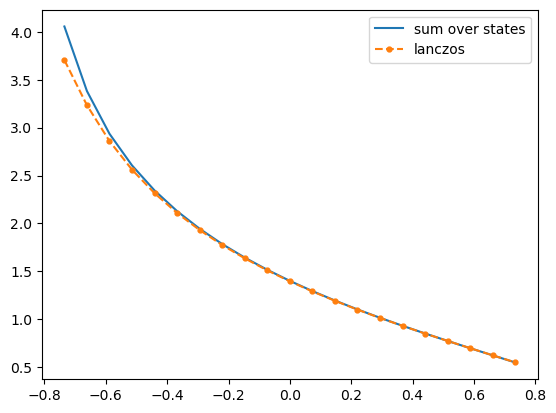

In [14]:
niter = 20
# print(en[jgw-1]*ryd2ev, " sigma_x=", sig_x, " sigma_c=", sig_c*ryd2ev, " vxc=", vxc)
# polynomial fit
print("omega_squared range:", min(omega_squared), max(omega_squared))
xx = np.linspace(min(omega_squared)*0.5, max(omega_squared)*1.5, 8) # rydberg
yy = np.sqrt(xx)
npoly = 5
polynomial = np.poly1d(np.polyfit(xx,yy,npoly))
print(polynomial)
#plt.plot(xx,polynomial(xx)-yy); plt.show()
Hpower = np.eye(ncv)
rcoefs = np.flip(polynomial.coef)
H_aux = np.zeros((ncv,ncv))
for a in rcoefs:
    H_aux = H_aux + Hpower * a
    if (a != rcoefs[-1]): 
        Hpower = Hpower @ C # matrix multiplication
# We can not directly use polynomial(C), since it computes C^2 = C*C (element-wise multiplication, which is not what we want)
#H_aux = polynomial(C)-a_0+a_0*np.eye(ncv, dtype=np.float64)

sig_c_lanczos = np.zeros(ne) # correlation part of GW self-energy
ie = 0
for dE in Elist:
    E = en[jgw-1] + dE # Rydberg, dft kohn-sham energy of orbital 
    incr = np.zeros(nb, dtype=np.float64) + 1e-8*1j
    for ib in range(nb):
        zz = E-en[ib]
        Pvec = np.zeros(ncv, dtype=np.float64)
        for jcv in range(ncv):
            jv = pairmap[jcv,0]
            jc = pairmap[jcv,1]
            Pvec[jcv] = K[jc, jv, ib, jgw-offsetgw]*(en[jc]-en[jv])**0.5
        pnorm = np.linalg.norm(Pvec)
        #print(pnorm)
        pvec = Pvec/pnorm
        if (ib > nv-1): # for unoccupied states
            incr[ib] = 2.0 * pnorm**2 /(zz+eta*1j)*( -lanczos_spectra(H_aux, 0, pvec, niter) \
               + lanczos_spectra(H_aux, eta*1j+zz, pvec, niter) )
        else: # for occupied states
            incr[ib] = 2.0 * pnorm**2 /(zz-eta*1j)*( -lanczos_spectra(H_aux, 0, pvec, niter) \
               + lanczos_spectra(H_aux, eta*1j-zz, pvec, niter) )
        #print(ib, en[ib], sig_cl[ib]/incr[ib].real)
        sig_c_lanczos[ie] = sig_c_lanczos[ie] + incr[ib]
        #if (ie == 2):
        #    print(ib, incr[ib].real)
    #if (ie == 1):   
    #    plt.plot(incr)
    #    plt.show()
    print(" E = %8.4f eV;"%(E*ryd2ev), " E^GW (E) = %18.14f eV"%(sig_c[ie]*ryd2ev), " E^GW_lanczos (E) = %18.14f eV"%(sig_c_lanczos[ie]*ryd2ev))
    ie = ie + 1

plt.plot(Elist, sig_c*ryd2ev, label='sum over states')
plt.plot(Elist, sig_c_lanczos*ryd2ev, marker='o', linestyle='--', markersize=3.5, label='lanczos')
#plt.plot(Elist, sig_c_lanczos*ryd2ev*2-sig_c*ryd2ev, label='lanczos')
#plt.ylim([-2,0])
plt.legend(loc='best')
plt.show()

[-3.29902983e-01 -1.49836348e-03  7.33278801e-06 -1.54290937e-04
 -6.73541679e-03  2.95743137e-01 -2.27433457e-05  7.56513324e-02
 -3.23246932e-05 -1.31643428e-05]
[-1.20492351e-01 -5.47255852e-04  2.67819606e-06 -5.63525605e-05
 -2.46001475e-03  1.08015956e-01 -8.30668207e-06  2.76305683e-02
 -1.18061324e-05 -4.80808815e-06]


C:\Users\gwwfr\AppData\Local\Temp\ipykernel_24388\3199335890.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  factE[jcv] = 1.0/(tmpE+eta*1j)


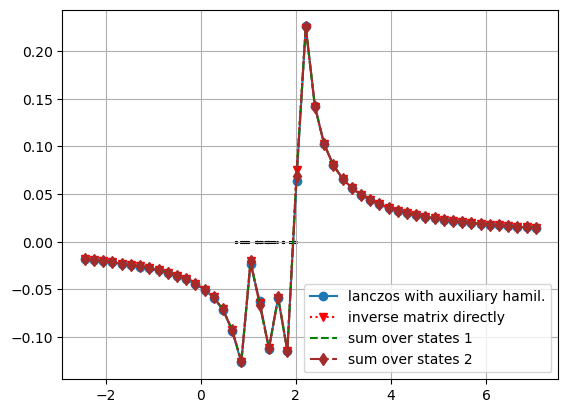

In [21]:
H = np.copy(C)
eigvals = np.linalg.eigvalsh(H)
Hpower = np.eye(ncv)
rcoefs = np.flip(polynomial.coef)
H_aux = np.zeros((ncv,ncv))
for a in rcoefs:
    H_aux = H_aux + Hpower * a
    if (a != rcoefs[-1]): 
        Hpower = Hpower @ C # matrix multiplication

ndim = len(H)
ib = 3
# Test 1: does not agree well
for jcv in range(ncv):
    jv = pairmap[jcv,0]
    jc = pairmap[jcv,1]
    Pvec[jcv] = K[jc, jv, ib, jgw-offsetgw]*(en[jc]-en[jv])**0.5 # 
#Pvec += np.random.rand(ndim)*np.linalg.norm(Pvec)*1e-3/ndim

# Test 2: random vector, different methods agree well
#np.random.seed(0)
#Pvec = np.exp(np.random.rand(ndim)) - 0.8
#Pvec = np.zeros(ndim); Pvec[1] = 0.5; Pvec[20] = -0.3

pnorm = np.linalg.norm(Pvec)
#print(pnorm)
v0 = Pvec/pnorm
#print(vec[-10:, 10])
print(v0[:10])
print(Pvec[:10])
eta = 1e-1

nz = 50
niter = 5
zl = np.linspace(-3+min(eigvals), 3+max(eigvals),nz)
sl = np.zeros(nz)+1e-9*1j
sl2 = np.zeros(nz)+1e-9*1j
sl3 = np.zeros(nz)+1e-9*1j
sl4 = np.zeros(nz)+1e-9*1j

for iz in range(nz):
    z = zl[iz]
    #sl[iz] = pnorm**2*lanczos_spectra(-z*H_aux+H, eta*1j, v0, niter)
    sl[iz] = pnorm**2*( -lanczos_spectra(H_aux, 0, v0, niter) +\
        lanczos_spectra(H_aux, z+eta*1j, v0, niter) )/(z+eta*1j)
    Hz = np.linalg.inv((z+eta*1j)*H_aux - H) 
    Hz_v0 = np.matmul(Hz, v0)
    v0_Hz_v0 = np.dot(v0, Hz_v0)
    sl2[iz] = v0_Hz_v0*pnorm**2
    sl3[iz] = 0.0
    factE = np.zeros(ncv)
    for jcv in range(ncv):
        tmpE = z - omega_squared[jcv]**0.5
        factE[jcv] = 1.0/(tmpE+eta*1j)
    sl3[iz] = np.sum(V[ib, :] * V[ib, :] * factE)
    sl4[iz] = 0.0
    for jcv in range(ncv):
        dprod = np.dot(Pvec, vec[:,jcv])
        efact = (1.0/np.sqrt(omega_squared[jcv])+1.0/(z+eta*1j-np.sqrt(omega_squared[jcv])))/(z+eta*1j)
        sl4[iz] = sl4[iz] + dprod**2.0*efact


fh = open("H_aux_v0.txt",'w')
fh.write("H_aux %5d \n"%(ncv))
for jcv in range(ncv):
    for icv in range(ncv):
        fh.write(" %8d %8d %16.10f \n"%(jcv, icv, H_aux[jcv,icv]))
fh.write("v0 %5d \n"%(ncv))
for jcv in range(ncv):
    fh.write("%5d %16.10f \n"%(jcv, v0[jcv]))
fh.write("z   -1/H_aux   1(z+eta*j-H_aux)   niter= %5d \n"%(niter))
for iz in range(nz):
    fh.write("%15.8f %15.8f %15.8f %15.8f \n"%(zl[iz], lanczos_spectra(H_aux, 0, v0, niter),  lanczos_spectra(H_aux, zl[iz]+eta*1j, v0, niter).real, lanczos_spectra(H_aux, zl[iz]+eta*1j, v0, niter).imag  ))
fh.close()


plt.plot(zl, sl.real, label='lanczos with auxiliary hamil.', marker='o')
plt.plot(zl, sl2.real, label='inverse matrix directly', linestyle=':', marker='v', color='red')
plt.plot(zl, sl3.real, label='sum over states 1', linestyle='--',color='green')
plt.plot(zl, sl4.real, label='sum over states 2', linestyle='-.', marker='d', color='brown')
plt.scatter(np.sqrt(eigvals), np.zeros(ndim), s=1.5, color='black')
#plt.xlim([-5,5])
#plt.ylim([-1,1])
plt.grid("on")
plt.legend(loc='best')
plt.show()

In [5]:
xx = np.linspace(min(omega_squared)*0.8, max(omega_squared)*1.2, 50)
yy = 1.0/xx
polynomial = np.poly1d(np.polyfit(xx,yy,12))
print(polynomial.coef)
shift = 10.0
invC = np.linalg.inv(C + shift*np.eye(ncv))
# compare polynomial and data points #
#plt.plot(xx,polynomial(xx))
#plt.plot(xx,yy,marker='o',markersize=0.5,linestyle='--')
# Show relative errors
#plt.plot(xx, np.abs((polynomial(xx)-yy)/yy))
#plt.ylim([0,1.0])
#plt.show()
# sum_over_eigvals
sum_eigs = np.sum(omega_squared)
print(sum_eigs)
sum_eigs_lanczos = 0.0
niter = 15
nsamp = 30
eps = 1e-5
for isamp in range(nsamp):
    v0 = np.random.rand(ncv)
    v0 = np.random.randint(low=-1,high=1, size=ncv)
    #v0 = v0.astype(float)/np.linalg.norm(v0)
    #v0 = np.zeros(ncv)
    #idx = np.random.randint(low=0,high=ncv-1)
    #v0[idx] = 1.0
    incr = lanczos_spectra(-invC,eps*1j,v0,niter)
    sum_eigs_lanczos += incr.real
    if(isamp%2 == 0):
        print(isamp, idx, sum_eigs_lanczos*ncv/(isamp+1) - shift*ncv)


[ 1.00886481e-04 -3.42205732e-03  5.20063730e-02 -4.67629866e-01
  2.76753530e+00 -1.13468824e+01  3.30391515e+01 -6.89054884e+01
  1.02505872e+02 -1.06967938e+02  7.57866695e+01 -3.43885693e+01
  8.92906165e+00]
186.57275664855698


NameError: name 'idx' is not defined